In [246]:
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from Levenshtein import ratio
from sklearn.feature_extraction.text import TfidfVectorizer
from autocorrect import Speller
import numpy as np
import jax
import jax.numpy as jnp
import json

In [2]:
ingr_path = 'data/flavor_network_data/ingr_comp/ingr_info.tsv'
ingr_tsv = pd.read_csv(ingr_path, delimiter='\t')

ingr_df = pd.DataFrame(data = ingr_tsv)
ingr_columns = ['ingredient_id', 'ingredient_name', 'ingredient_category']
ingr_df.columns = ingr_columns

In [12]:
sample_recipe = pd.read_csv('data/sample.csv')

In [13]:
sample_recipe = pd.DataFrame(sample_recipe)

sample_recipe['id'] = sample_recipe.index
sample_recipe.drop("Unnamed: 0", axis=1, inplace=True)

In [14]:
def clean_ingredient(ingredient):
    # Remove special characters and replace spaces with underscores, convert to lowercase
    cleaned = re.sub(r'[^a-zA-Z0-9\s]', '', ingredient).lower().replace(' ', '_')
    return cleaned.strip() if len(cleaned.strip()) >= 2 else None

# Function to process and clean the NER column
def process_and_clean_ner_column(ner_list):
    try:
        # Evaluate the string to a list if necessary
        if isinstance(ner_list, str):
            ner_list = eval(ner_list)
        # Ensure ner_list is actually a list
        if isinstance(ner_list, list):
            # Clean each ingredient in the list and remove duplicates
            cleaned_ingredients = list(set(clean_ingredient(ingredient) for ingredient in ner_list if clean_ingredient(ingredient) is not None))
            return cleaned_ingredients
        else:
            return ner_list
    except Exception as e:
        print(f"Error processing list: {e}")
        return ner_list  # Return the original list if there's an error

# Apply the cleaning function to the 'NER' column
sample_recipe['NER'] = sample_recipe['NER'].apply(process_and_clean_ner_column)


In [259]:
ingr_mapping_df

,ingredient_id,ingredient_name,ingredient_category
0,0,magnolia_tripetala,flower
1,1,calyptranthes_parriculata,plant
2,2,chamaecyparis_pisifera_oil,plant derivative
3,3,mackerel,fish/seafood
4,4,mimusops_elengi_flower,flower
...,...,...,...
1525,1525,tobacco_oil,plant derivative
1526,1526,cinnamon_leaf,plant
1527,1527,green_tea,plant derivative
1528,1528,artemisia_porrecta_oil,plant derivative


In [15]:
# Ensure all column names are strings
sample_recipe.columns = sample_recipe.columns.astype(str)

# Create a DataFrame to hold the new columns with initial values set to 0
ingredient_list = ingr_mapping_df['ingredient_name'].unique()
new_columns_ingr_df = pd.DataFrame(0, index=sample_recipe.index, columns=ingredient_list)

# Concatenate the new columns to sample_recipe
sample_recipe = pd.concat([sample_recipe, new_columns_ingr_df], axis=1)

# Iterate through sample_recipe NER column rows
for index, row in sample_recipe.iterrows():
    ingredients_list = row['NER']
    # Iterate through each value in the ingredients list
    for ingredient in ingredients_list:
        # Check if the ingredient matches any column name
        if ingredient in sample_recipe.columns:
            # Update the corresponding cell to 1
            sample_recipe.at[index, ingredient] = 1

In [16]:
sample_recipe

,NER,id,magnolia_tripetala,calyptranthes_parriculata,chamaecyparis_pisifera_oil,mackerel,mimusops_elengi_flower,hyssop,buchu,black_pepper,...,rue_oil,roasted_coconut,cajeput_oil,star_anise,feijoa,tobacco_oil,cinnamon_leaf,green_tea,artemisia_porrecta_oil,munster_cheese
0,"[flank_steak, brown_sugar, soy_sauce, sesame_s...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[carrots, water, handful_grape_tomatoes, mushr...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[carrots, brown_sugar, butter, lemon_rind]",2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[water, crisco, vinegar, salt, baking_powder, ...",3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[thin_pretzels, margarine]",4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"[ground_nutmeg, sultana, milk, rolled_oats, fr...",9995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,"[carrots, walnuts, mandarin_oranges, olive_oil...",9996,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9997,"[tomatoes, onion, longgrain_white_rice, ground...",9997,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,"[fingerling_potatoes, garlic, onion_salt, ital...",9998,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


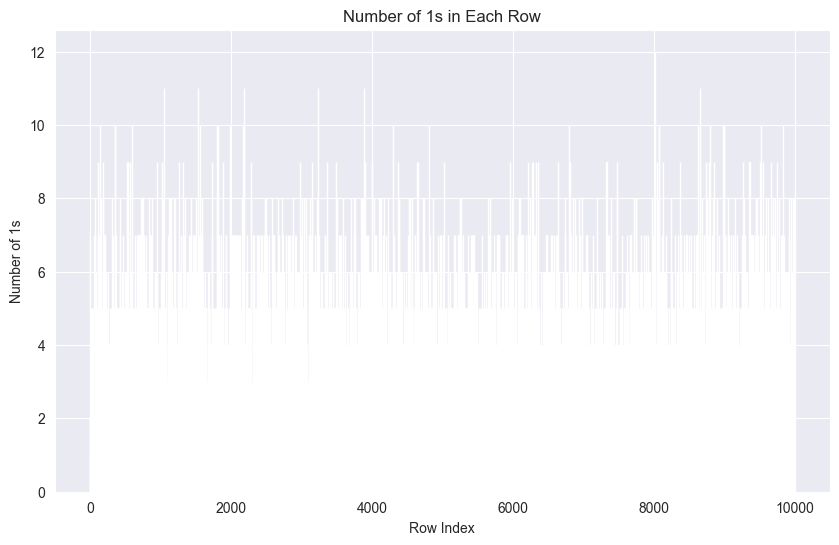

1.8487788911437826

In [17]:
# Calculate the number of 1s in each row
# Identify columns that are compound IDs
ingredient_cols = [col for col in sample_recipe.columns if col not in ['id', 'NER']]
sample_recipe['count_ones'] = sample_recipe[ingredient_cols].sum(axis=1)

# Plot the number of 1s in each row
plt.figure(figsize=(10, 6))
plt.bar(sample_recipe.index, sample_recipe['count_ones'])
plt.xlabel('Row Index')
plt.ylabel('Number of 1s')
plt.title('Number of 1s in Each Row')
plt.show()


In [18]:
sample_recipe['count_ones']

0       2
1       7
2       1
3       2
4       0
       ..
9995    4
9996    5
9997    1
9998    3
9999    8
Name: count_ones, Length: 10000, dtype: int64

In [19]:
# Initialize lists to store unmatched ingredients, all unique ingredients, and matched ingredients
unmatched_ingredients = []
all_unique_ingredients = set()
matched_ingredients = []

# Iterate through sample_recipe NER column rows
for index, row in sample_recipe.iterrows():
    ingredients_list = row['NER']
    # Convert the string representation of the list to an actual list if needed
    if isinstance(ingredients_list, str):
        ingredients_list = eval(ingredients_list)
    # Add ingredients to the all_unique_ingredients set
    all_unique_ingredients.update(ingredients_list)
    # Iterate through each value in the ingredients list
    for ingredient in ingredients_list:
        # Check if the ingredient matches any ingredient_name in ingr_mapping_df
        match = ingr_mapping_df[ingr_mapping_df['ingredient_name'] == ingredient]
        if not match.empty:
            ingredient_id = match['ingredient_id'].values[0]
            # Update the corresponding cell to 1
            sample_recipe.at[index, str(ingredient_id)] = 1
            # Add ingredient to matched_ingredients list
            matched_ingredients.append(ingredient)
        else:
            # If no match, add the ingredient to the unmatched_ingredients list
            unmatched_ingredients.append(ingredient)

# Convert all_unique_ingredients set to a list
all_unique_ingredients = list(all_unique_ingredients)

# Convert matched_ingredients list to a set and then back to a list to remove duplicates
matched_ingredients = list(set(matched_ingredients))

/var/folders/sx/vzszgjy10_z93jmql4144jnm0000gn/T/ipykernel_65410/1322866419.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sample_recipe.at[index, str(ingredient_id)] = 1
/var/folders/sx/vzszgjy10_z93jmql4144jnm0000gn/T/ipykernel_65410/1322866419.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sample_recipe.at[index, str(ingredient_id)] = 1
/var/folders/sx/vzszgjy10_z93jmql4144jnm0000gn/T/ipykernel_65410/1322866419.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

In [14]:
fuzz.partial_ratio('grnd_black_pepper', 'grinded_black_pepper')

88

In [15]:
fuzz.partial_ratio('black_pepper', 'bell_pepper')

73

In [ ]:
unmatched_ingredients

In [16]:
for ingredient in unmatched_list_unique:
 match = fuzz.partial_ratio(ingredient, 'grnd_black_pepper')
 if match > 70:
    print(f"{ingredient}: {match}")

grnd_black_pepper: 100
pepperoni: 80
red_bell_pepper: 73
ground_black_pepper: 88
green_bell_peppers: 76
freshly_ground_black_pepper: 88
orange_bell_pepper: 71
peppers: 92
fresh_ground_black_pepper: 88
black_peppercorns: 83
bell_peppers: 75
ground_red_pepper: 71
black: 100
sweet_red_bell_peppers: 73
whole_black_peppercorns: 76
freshly_cracked_black_pepper: 82
cracked_black_pepper: 82
red_bell_peppers: 75
freshground_black_pepper: 88
peppercorns: 71
periperi: 71
fresh_coarsely_ground_black_pepper: 88
monterey_jack_pepper_cheese: 71
n: 100
dusting_black_pepper: 82
paper: 80
fresh_coarse_ground_black_pepper: 88
dr_pepper: 78
coarse_black_pepper: 82
blac_pepper: 91
course_black_pepper: 82
rind: 75
peppercorn: 75
pack: 75
coarsegrind_black_pepper: 94
freshly_grnd_black_pepper: 100
celtic_sea_salt__cracked_black_pepper: 82
cracked_pepper: 77
coarsley_ground_black_pepper: 88
freshlygrnd_black_pepper: 100
generous_of_cracked_black_pepper: 82
peppermints: 71
sweet_red_bell_peppers_red_pepper: 71

In [32]:
ingredient_list = list(ingr_mapping_df['ingredient_name'])
ingredient_list

['magnolia_tripetala',
 'calyptranthes_parriculata',
 'chamaecyparis_pisifera_oil',
 'mackerel',
 'mimusops_elengi_flower',
 'hyssop',
 'buchu',
 'black_pepper',
 'eryngium_poterium_oil',
 'peanut_butter',
 'artemisia_verlo',
 'agastache_rugosa',
 'satureia_thymera',
 'petitgrain',
 'orris_root',
 'black_mustard_seed_oil',
 'celery_oil',
 'red_bean',
 'almond',
 'bacon',
 'lavender',
 'black_chokecherry',
 'abies_canadensis',
 'petitgrain_lemon',
 'keta_salmon',
 'jasmine_tea',
 'grapefruit_peel',
 'acacia_flower_oil',
 'nezara_viridula',
 'lemon_tree',
 'litchi',
 'filbert',
 'yellow_passion_fruit_juice',
 'jasmine',
 'congo_geranium',
 'maple_syrup',
 'vervain_leaf',
 'smoke',
 'toasted_oat',
 'reunion_geranium',
 'kabosu_peel_oil',
 'soybean',
 'wintergreen_leaf',
 'eucalyptus_hemilampra',
 'jammus_citronella_oil',
 'spike',
 'blueberry',
 'musk',
 'callitris_glauca',
 'red_currant',
 'myrrh',
 'pecan',
 'cicuta_virosa_oil',
 'purple_passion_fruit_juice',
 'caja_fruit',
 'juniper_le

In [76]:
perfect_match = []
list_ = ingredient_list.copy()
while list_:
    ingredient = list_.pop()
    for ingredient_2 in list_:
        matching_fraction = fuzz.partial_ratio(ingredient, ingredient_2)
        if matching_fraction == 100:
            perfect_match.append([ingredient, ingredient_2])

perfect_match = [[i,j] if len(i)>=len(j) else [j,i] for i,j in perfect_match]
perfect_match = np.array(perfect_match)
perfect_match_list = list(perfect_match.flatten())
perfect_match_list_new = []
while perfect_match_list:
    element = perfect_match_list.pop()
    if element not in perfect_match_list:
        perfect_match_list_new.append(element)

ingredient_list_new = perfect_match_list_new + list(set(ingredient_list) - set(perfect_match_list_new))

In [260]:
ingredient_dic = dict(enumerate(ingredient_list_new))
ingredient_dic = {ingredient: [] for ingredient in ingredient_list_new}

In [77]:
unmatched_list_unique = list(pd.Series(unmatched_ingredients).unique())

In [160]:
unmatched_list_ = unmatched_list_unique.copy()
matching_pair_list = []
for ingredient in ingredient_list_new:
    for ingredient_2 in unmatched_list_:
        matching_fraction = fuzz.token_set_ratio(ingredient, ingredient_2)
        if matching_fraction >= 92:
            unmatched_list_.remove(ingredient_2)
            matching_pair = [ingredient, ingredient_2]
            matching_pair_list.append(matching_pair)

In [81]:
'sweet_potato' in ingredient_dic

False

In [175]:
dic_append = []
for i, i_1 in matching_pair_list: 
    x = f"ingredient_dic['{i}'].append('{i_1}')"
    dic_append.append(x)
dic_append

["ingredient_dic['japanese_mint'].append('japanese_egglant')",
 "ingredient_dic['smoked_summer_sausage'].append('summer_sausage')",
 "ingredient_dic['smoked_sausage'].append('sage_sausage')",
 "ingredient_dic['celery_seed'].append('celery_washed')",
 "ingredient_dic['celery_oil'].append('celery_soup')",
 "ingredient_dic['celery_oil'].append('celery_salt')",
 "ingredient_dic['licorice'].append('licor')",
 "ingredient_dic['hazelnut'].append('hazelnut_meal')",
 "ingredient_dic['roasted_hazelnut'].append('ground_hazelnuts')",
 "ingredient_dic['cod'].append('scrod')",
 "ingredient_dic['roasted_beef'].append('stew_beef')",
 "ingredient_dic['cherry_juice'].append('cherry_jello')",
 "ingredient_dic['cherry_juice'].append('carrot_juice')",
 "ingredient_dic['grilled_beef'].append('grnd_beef')",
 "ingredient_dic['irish_whiskey'].append('rye_whiskey')",
 "ingredient_dic['red_meat'].append('red_beet')",
 "ingredient_dic['rapeseed'].append('grapeseed_oil')",
 "ingredient_dic['rapeseed'].append('rape

In [261]:
#unmatched_list_5
ingredient_dic['smoked_summer_sausage'].append('summer_sausage')
ingredient_dic['sage'].append('sage_sausage')
ingredient_dic['celery'].append('celery_washed')
ingredient_dic['celery_oil'].append('celery_salt')
ingredient_dic['hazelnut'].append('hazelnut_meal')
ingredient_dic['roasted_hazelnut'].append('ground_hazelnuts')
ingredient_dic['roasted_beef'].append('stew_beef')
ingredient_dic['carrot'].append('carrot_juice')
ingredient_dic['beef'].append('grnd_beef')
ingredient_dic['irish_whiskey'].append('rye_whiskey')
ingredient_dic['rapeseed'].append('rapeseed_oil')
ingredient_dic['potato'].append('red_potatoes')
ingredient_dic['potato'].append('red_potato')
ingredient_dic['baked_potato'].append('baking_potato')
ingredient_dic['potato'].append('baby_red_potato')
ingredient_dic['potato'].append('baby_red_potatoes')
ingredient_dic['potato'].append('russet_potato')
ingredient_dic['sweet_potato'].append('sweet_potato_filling')
ingredient_dic['pea'].append('sweet_pea')
ingredient_dic['potato'].append('white_potato')
ingredient_dic['sweet_potato'].append('peeled_sweet_potato')
ingredient_dic['tea'].append('sweet_tea')
ingredient_dic['tomato'].append('sweet_tomatoes')
ingredient_dic['buttermilk'].append('sweet_milk')
ingredient_dic['rice'].append('jasmine_rice')
ingredient_dic['watermelon'].append('cubes_watermelon')
ingredient_dic['watermelon'].append('watermelon_rind')
ingredient_dic['pork'].append('fresh_pork')
ingredient_dic['red_currant'].append('fresh_currants')
ingredient_dic['garlic'].append('garlic_salt')
ingredient_dic['coconut'].append('coconut_flakes')
ingredient_dic['corn_oil'].append('corn_oil_oleo')
ingredient_dic['macadamia_nut'].append('macadamias')
ingredient_dic['crisp_bread'].append('crusty_bread')
ingredient_dic['rice'].append('crisp_rice')
ingredient_dic['roasted_beef'].append('beef_roast')
ingredient_dic['beef_broth'].append('beef_broth_made')
ingredient_dic['beef_broth'].append('beef_broth_see')
ingredient_dic['lavender'].append('dried_lavender')
ingredient_dic['cheese'].append('mature_cheese')
ingredient_dic['cheese'].append('farmer_cheese')
ingredient_dic['cheese'].append('shredded_cheese')
ingredient_dic['cheese'].append('sharp_cheese')
ingredient_dic['cheese'].append('chevre_cheese')
ingredient_dic['cheese'].append('three_cheese')
ingredient_dic['mozzarella_cheese'].append('white_cheese')
ingredient_dic['cheese'].append('other_cheese')
ingredient_dic['cheese'].append('milk_cheese')
ingredient_dic['cheese'].append('left_cheese')
ingredient_dic['cheese'].append('lots_cheese')
ingredient_dic['cheese'].append('chili_cheese')
ingredient_dic['cheddar_cheese'].append('cheddar_cheese_slice')
ingredient_dic['cheddar_cheese'].append('cheddar_cheese_target')
ingredient_dic['cheddar_cheese'].append('cheddar_slices')
ingredient_dic['cheese'].append('diced_cheese')
ingredient_dic['cheddar_cheese'].append('cheddar_cheese_shred')
ingredient_dic['cottage_cheese'].append('lowfat_cottage_cheese')
ingredient_dic['cottage_cheese'].append('cotija_cheese')
ingredient_dic['cheese'].append('aged_cheese')
ingredient_dic['cheddar_cheese'].append('chipotle_cheese')
ingredient_dic['celery'].append('selery')
ingredient_dic['port_wine'].append('tawny_port_wine')
ingredient_dic['rye_bread'].append('loaf_rye_bread')
ingredient_dic['rye_bread'].append('rye_breadcrumbs')
ingredient_dic['rye_bread'].append('dark_rye_bread')
ingredient_dic['rye_bread'].append('party_rye_bread')
ingredient_dic['bread'].append('fresh_bread')
ingredient_dic['sage'].append('fresh_sage')
ingredient_dic['boiled_pork'].append('boiled_ham')
ingredient_dic['roasted_meat'].append('stew_meat')
ingredient_dic['cheese'].append('colby_cheese')
ingredient_dic['cheese'].append('mixed_cheese')
ingredient_dic['cheese'].append('taco_cheese')
ingredient_dic['cape_gooseberry'].append('gooseberry')
ingredient_dic['wine'].append('rice_wine')
ingredient_dic['red_wine'].append('good_red_wine')
ingredient_dic['red_kidney_bean'].append('red_kidney')
ingredient_dic['red_wine'].append('dry_wine')
ingredient_dic['mashed_potato'].append('hot_mashed_potatoes')
ingredient_dic['sweet_potato'].append('mashed_sweet_potatoes')
ingredient_dic['mashed_potato'].append('cold_mashed_potatoes')
ingredient_dic['beef'].append('cubed_beef')
ingredient_dic['passion_fruit_wine'].append('passion_fruit_syrup')
ingredient_dic['purple_passion_fruit'].append('curd_recipe_passionfruit')
ingredient_dic['brown_rice'].append('brown_rice_flour')
ingredient_dic['brown_rice'].append('brown_rice_syrup')
ingredient_dic['grapefruit_oil'].append('grapefruit_soda')
ingredient_dic['shrimp'].append('tiny_shrimp')
ingredient_dic['swiss_cheese'].append('whiz_cheese')
ingredient_dic['swiss_cheese'].append('colbyswiss_cheese')
ingredient_dic['rice'].append('white_rice')
ingredient_dic['bean'].append('white_beans')
ingredient_dic['white_bread'].append('pita_bread')
ingredient_dic['white_bread'].append('white_breadcrumbs')
ingredient_dic['white_bread'].append('crusty_white_bread')
ingredient_dic['white_bread'].append('loaves_white_bread')
ingredient_dic['cream'].append('white_cream')
ingredient_dic['white_bread'].append('thin_white_bread')
ingredient_dic['white_bread'].append('white_breadcrumb')
ingredient_dic['chicken'].append('white_meat')
ingredient_dic['radish'].append('white_radish')
ingredient_dic['white_bread'].append('white_loaf_bread')
ingredient_dic['onion'].append('spanish_onion')
ingredient_dic['strawberry_jam'].append('strawberry_jello')
ingredient_dic['gelatin'].append('strawberry_gelatin')
ingredient_dic['strawberry'].append('strawberry_halves')
ingredient_dic['strawberry_jam'].append('strawberry_mousse')
ingredient_dic['strawberry_jam'].append('berry_jam')
ingredient_dic['strawberry'].append('strawberries')
ingredient_dic['salmon'].append('red_salmon')
ingredient_dic['lemon'].append('grated_lemon')
ingredient_dic['horseradish'].append('horseradish_root')
ingredient_dic['brandy'].append('cheap_brandy')
ingredient_dic['ginger'].append('ginger_root')
ingredient_dic['rum'].append('cinnamon_rum')
ingredient_dic['cinnamon'].append('cinnamon_stick')
ingredient_dic['cinnamon'].append('cinnamon_red')
ingredient_dic['cinnamon'].append('cinnamon_inch')
ingredient_dic['tea'].append('cold_tea')
ingredient_dic['lavender'].append('lavender_buds')
ingredient_dic['guava'].append('guava_jelly')
ingredient_dic['guava'].append('guava_paste')
ingredient_dic['sugarcane'].append('cane_syrup')
ingredient_dic['lingonberry'].append('lingonberry_butter')
ingredient_dic['lingonberry'].append('fresh_lingonberry')
ingredient_dic['egg'].append('eggs_')
ingredient_dic['egg_noodle'].append('wide_egg_noodles')
ingredient_dic['egg_noodle'].append('thin_egg_noodles')
ingredient_dic['corn_tortilla'].append('flour_tortilla')
ingredient_dic['corn_tortilla'].append('flour_tortillas')
ingredient_dic['corn_tortilla'].append('tortilla')
ingredient_dic['fish'].append('solid_fish')
ingredient_dic['smoke'].append('fire_oil')
ingredient_dic['whitefish'].append('firm_white_fish')
ingredient_dic['whitefish'].append('whiting_fish')
ingredient_dic['shellfish'].append('shellfish_stock')
ingredient_dic['shellfish'].append('shells')
ingredient_dic['elder_flower'].append('elderflower_syrup')
ingredient_dic['sunflower_oil'].append('sunflower')
ingredient_dic['pea'].append('sweet_peas')
ingredient_dic['coffee'].append('hot_coffee')
ingredient_dic['coffee'].append('coffee_reg')
ingredient_dic['black_tea'].append('black_tea_leaves')
ingredient_dic['parsley'].append('fresh_parsley')
ingredient_dic['basil'].append('dried_basil')
ingredient_dic['gruyere_cheese'].append('shredded_gruyere_cheese')
ingredient_dic['blackberry'].append('blackberries')
ingredient_dic['blackberry'].append('blackberry_jam')
ingredient_dic['blackberry'].append('blackberry_jello')
ingredient_dic['sherry'].append('dry_sherry')
ingredient_dic['vinegar'].append('sherry_vinegar')
ingredient_dic['sherry_wine'].append('sherry_sweet')
ingredient_dic['sherry_wine'].append('white_sherry_wine')
ingredient_dic['coconut'].append('coconut_flour')
ingredient_dic['coconut_oil'].append('virgin_coconut_oil')
ingredient_dic['coconut_oil'].append('nut_oil')
ingredient_dic['coconut'].append('coconut_chips')
ingredient_dic['rancid_coconut_oil'].append('unrefined_coconut_oil')
ingredient_dic['cinnamon'].append('cinnamon_cinnamon')
ingredient_dic['fried_beef'].append('corned_beef')
ingredient_dic['cinnamon'].append('ground_cinnamon')
ingredient_dic['cinnamon'].append('ground_cinnamon_')
ingredient_dic['garlic'].append('roasted_garlic')
ingredient_dic['cloudberry'].append('cloudberries')
ingredient_dic['cheese'].append('lemon_cheese')
ingredient_dic['cheese'].append('brie_cheese')
ingredient_dic['cheese'].append('nobake_cheese')
ingredient_dic['cheese'].append('blocks_cheese')
ingredient_dic['olive_oil'].append('light_olive_oil')
ingredient_dic['olive_oil'].append('olive_oil_oil')
ingredient_dic['olive_oil'].append('veg_oil')
ingredient_dic['olive_oil'].append('olive_oil_spray')
ingredient_dic['apple'].append('red_apple')
ingredient_dic['butter'].append('batter')
ingredient_dic['butter'].append('tbsbutter')
ingredient_dic['fish'].append('butterfish')
ingredient_dic['butter'].append('butcher')
ingredient_dic['butter'].append('sunbutter')
ingredient_dic['butter'].append('tbl_butter')
ingredient_dic['buttermilk'].append('buttermilk_notes')
ingredient_dic['buttermilk'].append('warm_buttermilk')
ingredient_dic['shrimp'].append('peeled_shrimp')
ingredient_dic['capsicum'].append('red_capsicum')
ingredient_dic['starch'].append('potato_starch')
ingredient_dic['potato_chip'].append('potato_chip_crumbs')
ingredient_dic['grapefruit_juice'].append('white_grapefruit_juice')
ingredient_dic['passion_fruit'].append('passionfruit_pulp')
ingredient_dic['almond'].append('almond_flavoring')
ingredient_dic['almond'].append('almond_flakes')
ingredient_dic['cheese'].append('processed_cheese')
ingredient_dic['pork'].append('boneless_pork')
ingredient_dic['horseradish_oil'].append('horseradish_sauce')
ingredient_dic['horseradish_oil'].append('horseradish_cream')
ingredient_dic['horseradish'].append('white_horseradish')
ingredient_dic['horseradish'].append('ground_horseradish')
ingredient_dic['pear'].append('pear_juice')
ingredient_dic['grape_juice'].append('fresh_grape_juice')
ingredient_dic['grape_juice'].append('white_grape_juice')
ingredient_dic['skim_milk'].append('cold_skim_milk')
ingredient_dic['fruit'].append('tropical_fruit')
ingredient_dic['spearmint'].append('fresh_spearmint')
ingredient_dic['pear_brandy'].append('jigger_pear_brandy')
ingredient_dic['spearmint'].append('spearmint_leaves')
ingredient_dic['bartlett_pear'].append('bartlett')
ingredient_dic['raspberry'].append('raspberries')
ingredient_dic['roasted_onion'].append('french_fried_onion')
ingredient_dic['vegetable'].append('vegetable_stock')
ingredient_dic['vegetable_oil'].append('vegetable_broth')
ingredient_dic['vegetable'].append('vegetable_juice')
ingredient_dic['vegetable_oil'].append('vegetable_soup')
ingredient_dic['vegetable'].append('baby_vegetables')
ingredient_dic['vegetable'].append('vegetable_blend')
ingredient_dic['vegetable_oil'].append('vegetable_oil_spray')
ingredient_dic['vegetable'].append('vegetable_protein')
ingredient_dic['vegetable_oil'].append('vegetable_soup_mix')
ingredient_dic['vegetable'].append('vegetable_filling')
ingredient_dic['vegetable_oil'].append('light_vegetable_oil')
ingredient_dic['vegetable_oil'].append('vegetable_oil_garlic')
ingredient_dic['vegetable_oil'].append('vegetables_maple')
ingredient_dic['vegetable_oil'].append('sugar_vegetable_oil')
ingredient_dic['vegetable'].append('vegetable_medley')
ingredient_dic['beef'].append('beef_flavor')
ingredient_dic['banana'].append('banana_mix')
ingredient_dic['cream'].append('creme')
ingredient_dic['cream'].append('creamer')
ingredient_dic['cream'].append('of_cream')
ingredient_dic['cream_cheese'].append('weight_cream_cheese')
ingredient_dic['cream_cheese'].append('garlic_cream_cheese')
ingredient_dic['cream_cheese'].append('packets_cream_cheese')
ingredient_dic['cream_cheese'].append('onion_cream_cheese')
ingredient_dic['cream_cheese'].append('lowfat_cream_cheese')
ingredient_dic['cream_cheese'].append('lite_cream_cheese')
ingredient_dic['cream_cheese'].append('cream_brie_cheese')
ingredient_dic['cream_cheese'].append('brick_cream_cheese')
ingredient_dic['cream_cheese'].append('nonfat_cream_cheese')
ingredient_dic['cream_cheese'].append('light_cream_cheese')
ingredient_dic['cheese'].append('curd_cheese')
ingredient_dic['cream_cheese'].append('white_cream_cheese')
ingredient_dic['lemongrass'].append('lemongrass_stem')
ingredient_dic['lemongrass'].append('stalk_lemongrass')
ingredient_dic['lemon_peel'].append('lemon_peel_seasoning')
ingredient_dic['lemon_juice'].append('lemon_juice_only')
ingredient_dic['lemon'].append('lemon_slice')
ingredient_dic['lemon'].append('lemon_slices')
ingredient_dic['lemon_juice'].append('lemon_sauce')
ingredient_dic['lemon_juice'].append('lemon_juice_well')
ingredient_dic['lemon'].append('lemon_lime')
ingredient_dic['lemongrass'].append('lemongrass_stalks')
ingredient_dic['peach'].append('peaches')
ingredient_dic['mustard'].append('grain_mustard')
ingredient_dic['mustard'].append('grainy_mustard')
ingredient_dic['cured_ham'].append('corned_ham')
ingredient_dic['peanut_butter'].append('crunchy_peanut_butter')
ingredient_dic['peanut_butter'].append('smooth_peanut_butter')
ingredient_dic['peanut_butter'].append('chunky_peanut_butter')
ingredient_dic['peanut_butter'].append('peanut_brittle')
ingredient_dic['peanut_butter'].append('natural_peanut_butter')
ingredient_dic['peanut_butter'].append('pats_butter')
ingredient_dic['asparagus'].append('fresh_asparagus')
ingredient_dic['asparagus'].append('white_asparagus')
ingredient_dic['asparagus'].append('green_asparagus')
ingredient_dic['asparagus'].append('cans_asparagus')
ingredient_dic['asparagus'].append('slim_asparagus')
ingredient_dic['asparagus'].append('stalk_asparagus')
ingredient_dic['asparagus'].append('thin_asparagus')
ingredient_dic['raw_asparagus'].append('stalks_asparagus')
ingredient_dic['raw_asparagus'].append('frozen_asparagus')
ingredient_dic['wheat_bread'].append('whole_wheat_bread')
ingredient_dic['wheat_bread'].append('wholemeal_bread')
ingredient_dic['wheat_bread'].append('loaf_wheat_bread')
ingredient_dic['grape_must'].append('grape_nuts')
ingredient_dic['buckwheat'].append('buckwheat_flour')
ingredient_dic['popcorn'].append('poupon')
ingredient_dic['cooked_apple'].append('cooking_apples')
ingredient_dic['apple_sauce'].append('tart_applesauce')
ingredient_dic['apple_sauce'].append('jar_applesauce')
ingredient_dic['apple'].append('apple_slices')
ingredient_dic['plum'].append('plum_sauce')
ingredient_dic['pineapple'].append('fresh_pineapple')
ingredient_dic['pineapple'].append('green_pineapple')
ingredient_dic['pineapple'].append('thin_pineapple')
ingredient_dic['pineapple'].append('sweet_pineapple')
ingredient_dic['pineapple'].append('pineapple_rings')
ingredient_dic['kaffir_lime'].append('fresh_kaffir_lime')
ingredient_dic['plum'].append('italian_plum')
ingredient_dic['lime'].append('lime_slice')
ingredient_dic['lime'].append('lime_slices')
ingredient_dic['lime_juice'].append('some_juice')
ingredient_dic['cheese'].append('american_cheese')
ingredient_dic['cardamom'].append('cardamom_pods')
ingredient_dic['cardamom'].append('cardamomclove')
ingredient_dic['mozzarella_cheese'].append('nonfat_mozzarella_cheese')
ingredient_dic['mozzarella_cheese'].append('lowfat_mozzarella_cheese')
ingredient_dic['cabbage'].append('white_cabbage')
ingredient_dic['pork_sausage'].append('hot_sausage')
ingredient_dic['pork_sausage'].append('ground_pork_sausage')
ingredient_dic['pork_sausage'].append('bulk_sausage')
ingredient_dic['pork_sausage'].append('pork_sausage_meat')
ingredient_dic['pork_sausage'].append('pork_sausage_links')
ingredient_dic['tomato'].append('tomatotes')
ingredient_dic['tomato'].append('tomaoes')
ingredient_dic['tomato'].append('tomatillo')
ingredient_dic['tomato'].append('tomatillos')
ingredient_dic['tomato'].append('tomato_puree')
ingredient_dic['tomato'].append('tomato_sauce')
ingredient_dic['tomato'].append('tomato_slices')
ingredient_dic['tomato'].append('tomato_pure')
ingredient_dic['tomato'].append('tomatoe_sauce')
ingredient_dic['walnut'].append('walmuts')
ingredient_dic['orange_oil'].append('orangeflavor')
ingredient_dic['orange_oil'].append('orange_flavoring')
ingredient_dic['orange_juice'].append('fresh_orange_juice')
ingredient_dic['orange_oil'].append('orange_butter')
ingredient_dic['orange'].append('orange_sauce')
ingredient_dic['orange'].append('orange_slices')
ingredient_dic['orange'].append('orange_slice')
ingredient_dic['orange_juice'].append('orange_juice_with')
ingredient_dic['orange_juice'].append('orange_juice_fresh')
ingredient_dic['ginger'].append('ginger_juice')
ingredient_dic['pecan'].append('peacans')
ingredient_dic['coriander'].append('coriander_seed')
ingredient_dic['coriander'].append('dried_coriander')
ingredient_dic['coriander'].append('fresh_coriander')
ingredient_dic['coriander'].append('coriander_seeds')
ingredient_dic['coriander'].append('whole_coriander')
ingredient_dic['coriander'].append('coriander_powder')
ingredient_dic['coriander'].append('coriander_ground')
ingredient_dic['coriander'].append('coriander_leaves')
ingredient_dic['coriander'].append('coriander_sprigs')
ingredient_dic['grilled_pork'].append('pulled_pork')
ingredient_dic['tomato'].append('green_tomatoes')
ingredient_dic['apple'].append('green_apple')
ingredient_dic['tomato'].append('green_tomato')
ingredient_dic['mango'].append('green_mangoes')
ingredient_dic['sparkling_wine'].append('fluid_sparkling_wine')
ingredient_dic['elderberry'].append('elderberries')
ingredient_dic['angelica'].append('frangelico')
ingredient_dic['rooibus_tea'].append('bagsrooibos_tea')
ingredient_dic['romano_cheese'].append('fresh_romano_cheese')
ingredient_dic['cheese'].append('manchego_cheese')
ingredient_dic['lemon'].append('lemon_flavored')
ingredient_dic['lemon'].append('lemon_flavor')
ingredient_dic['safflower_seed'].append('safflower')
ingredient_dic['basil'].append('torn_basil')
ingredient_dic['ginger'].append('gingerroot')
ingredient_dic['ginger'].append('ginger_paste')
ingredient_dic['ginger'].append('ginger_grated')
ingredient_dic['salmon'].append('salmon_filet')
ingredient_dic['salmon'].append('salmon_fillet')
ingredient_dic['almond'].append('almond_milk')
ingredient_dic['salmon'].append('salmon_fillets')
ingredient_dic['raw_potato'].append('brown_potatoes')
ingredient_dic['sour_cherry'].append('sour_cherries')
ingredient_dic['raw_chicken'].append('chicken_breast')
ingredient_dic['raw_chicken'].append('chicken_breasts')
ingredient_dic['chicken'].append('chicken_gumbo')
ingredient_dic['raw_chicken'].append('chicken_thigh')
ingredient_dic['chicken_broth'].append('lowsalt_chicken_broth')
ingredient_dic['chicken_broth'].append('chicken_fat')
ingredient_dic['chicken_broth'].append('chicken_brothstock')
ingredient_dic['raw_chicken'].append('chicken_parts')
ingredient_dic['raw_chicken'].append('chicken_breasts_')
ingredient_dic['raw_chicken'].append('chicken_mince')
ingredient_dic['chicken'].append('chicken_flavored')
ingredient_dic['chicken'].append('chicken_flavor')
ingredient_dic['rice'].append('chicken_rice')
ingredient_dic['raw_chicken'].append('whole_chickens')
ingredient_dic['raw_chicken'].append('white_chicken')
ingredient_dic['raw_chicken'].append('range_chicken')
ingredient_dic['fried_chicken'].append('fryer_chickens')
ingredient_dic['chicken'].append('favorite_chicken')
ingredient_dic['lemon'].append('realemon')
ingredient_dic['lemon'].append('lemon_optional')
ingredient_dic['blueberry'].append('blueberries')
ingredient_dic['blueberry'].append('blueberry_jam')
ingredient_dic['raw_turkey'].append('lean_turkey')
ingredient_dic['red_kidney_bean'].append('dark_red_kidney_beans')
ingredient_dic['kidney_bean'].append('white_kidney_beans')
ingredient_dic['red_kidney_bean'].append('light_red_kidney_beans')
ingredient_dic['lima_bean'].append('baby_lima_beans')
ingredient_dic['navy_bean'].append('dry_navy_beans')
ingredient_dic['bourbon_whiskey'].append('cheap_bourbon_whiskey')
ingredient_dic['nutmeg'].append('nutmet')
ingredient_dic['honey'].append('tb_honey')
ingredient_dic['apple_juice'].append('apple_juice_frozen')
ingredient_dic['roasted_spanish_peanut'].append('spanish_peanuts')
ingredient_dic['mustard'].append('dry_mustard')
ingredient_dic['mustard'].append('hot_mustard')
ingredient_dic['cauliflower'].append('head_cauliflower')
ingredient_dic['cauliflower'].append('weight_cauliflower')
ingredient_dic['cauliflower'].append('cauliflower_rice')
ingredient_dic['raspberry'].append('fresh_raspberry')
ingredient_dic['vinegar'].append('black_raspberry_vinegar')
ingredient_dic['whole_grain_wheat_flour'].append('wholewheat_flour')
ingredient_dic['whole_grain_wheat_flour'].append('white_wheat_flour')
ingredient_dic['whole_grain_wheat_flour'].append('whole_wheat_cake_flour')
ingredient_dic['anise_seed'].append('aniseed')
ingredient_dic['anise_seed_oil'].append('anise_oil')
ingredient_dic['roasted_pork'].append('barbecued_pork')
ingredient_dic['fennel'].append('fennel_bulb')
ingredient_dic['vinegar'].append('wine_vinegar')
ingredient_dic['vinegar'].append('mild_vinegar')
ingredient_dic['wood_vinegar'].append('dill_vinegar')
ingredient_dic['wood'].append('wooden')
ingredient_dic['vanilla_oil'].append('canola_oil')
ingredient_dic['vanilla_oil'].append('vanilla_soy_milk')
ingredient_dic['vanilla'].append('vanilla_pod')
ingredient_dic['vanilla'].append('vanilla_fat')
ingredient_dic['parmesan'].append('parmesan_chz')
ingredient_dic['cream_cheese'].append('marscapone_cheese')
ingredient_dic['cheese'].append('mexican_cheese')
ingredient_dic['cheese'].append('process_cheese')
ingredient_dic['parmesan_cheese'].append('parmesan_cheese_shavings')
ingredient_dic['grapefruit'].append('pink_grapefruits')
ingredient_dic['marjoram'].append('leaf_marjoram')
ingredient_dic['marjoram'].append('whole_marjoram')
ingredient_dic['sesame_seed'].append('sesame_seeds_white')
ingredient_dic['sesame_seed'].append('sesame_seeds_for')
ingredient_dic['sesame_seed'].append('white_sesame_seeds')
ingredient_dic['sesame_seed'].append('brown_sesame_seeds')
ingredient_dic['orange'].append('orange_and')
ingredient_dic['cheese'].append('velveeta_cheese')
ingredient_dic['cheese'].append('fontina_cheese')
ingredient_dic['cheese'].append('flavor_cheese')
ingredient_dic['cheese'].append('weight_cheese')
ingredient_dic['cheese'].append('velvetta_cheese')
ingredient_dic['onion'].append('white_onion')
ingredient_dic['vinegar'].append('white_vinegar')
ingredient_dic['white_wine'].append('cheap_white_wine')
ingredient_dic['white_wine'].append('sweet_white_wine')
ingredient_dic['white_wine'].append('tart_white_wine')
ingredient_dic['artichoke'].append('baby_artichokes')
ingredient_dic['artichoke'].append('artichoke_heart')
ingredient_dic['artichoke'].append('baby_artichoke')
ingredient_dic['oatmeal'].append('oatmeal_mix')
ingredient_dic['milk'].append('hot_milk')
ingredient_dic['milk'].append('nonfat_milk')
ingredient_dic['milk'].append('non_fat_milk')
ingredient_dic['milk'].append('lowfat_milk')
ingredient_dic['cheese'].append('grated_cheese')
ingredient_dic['cheese'].append('asiago_cheese')
ingredient_dic['cheese'].append('oaxaca_cheese')
ingredient_dic['malay_apple'].append('gala_apples')
ingredient_dic['strawberry_juice'].append('strawberry_puree')
ingredient_dic['strawberry_juice'].append('strawberry_syrup')
ingredient_dic['raspberry_juice'].append('raspberry_vinegar')
ingredient_dic['raspberry_juice'].append('raspberry_juice_blend')
ingredient_dic['blackberry_juice'].append('blackberrycranberry_juice')
ingredient_dic['cayenne'].append('red_cayenne')
ingredient_dic['onion'].append('fresh_onions')
ingredient_dic['onion'].append('red_onion')
ingredient_dic['onion'].append('red_onions')
ingredient_dic['wheat'].append('or_wheat')
ingredient_dic['bread'].append('breading')
ingredient_dic['bread'].append('breaf')
ingredient_dic['currant_leaf'].append('curry_leaf')
ingredient_dic['sage'].append('sage_leaf')
ingredient_dic['bay'].append('bay_leaf')
ingredient_dic['peppermint'].append('mint_leaf')
ingredient_dic['wintergreen_leaf'].append('green_leaf')
ingredient_dic['peppermint'].append('fresh_pepper')
ingredient_dic['black_pepper'].append('ground_pepper')
ingredient_dic['black_pepper'].append('grnd_pepper')
ingredient_dic['thai_pepper'].append('red_pepper')
ingredient_dic['bell_pepper'].append('yellow_bell_pepper')
ingredient_dic['bell_pepper'].append('orange_bell_pepper')
ingredient_dic['bell_pepper'].append('sweet_bell_peppers')
ingredient_dic['bell_pepper'].append('yellow_pepper')
ingredient_dic['bell_pepper'].append('yellow_peppers')
ingredient_dic['peppermint'].append('peppermint_leaf')
ingredient_dic['black_pepper'].append('grnd_black_pepper')
ingredient_dic['green_bell_pepper'].append('green_pepper')
ingredient_dic['green_bell_pepper'].append('green_peppers')
ingredient_dic['green_bell_pepper'].append('green_serrano_pepper')
ingredient_dic['green_bell_pepper'].append('grnd_red_pepper')
ingredient_dic['green_bell_pepper'].append('red_sweet_bell_pepper')
ingredient_dic['thai_pepper'].append('green_chili_peppers')
ingredient_dic['green_bell_pepper'].append('green_sweet_peppers')
ingredient_dic['green_bell_pepper'].append('green_sweet_pepper')
ingredient_dic['thai_pepper'].append('green_chili_pepper')
ingredient_dic['green_bell_pepper'].append('green_chile_peppers')
ingredient_dic['bell_pepper'].append('peppadew_bell_pepper')
ingredient_dic['bell_pepper'].append('jarred_red_bell_pepper')
ingredient_dic['bell_pepper'].append('orange_belle_pepper')
ingredient_dic['bell_pepper'].append('thin_red_bell_pepper')
ingredient_dic['tabasco_pepper'].append('hot_pepper')
ingredient_dic['ashanti_pepper'].append('sichuan_pepper')
ingredient_dic['tabasco_pepper'].append('habanero_pepper')
ingredient_dic['pepper'].append('white_pepper')
ingredient_dic['thai_pepper'].append('chili_peppers')
ingredient_dic['thai_pepper'].append('chili_pepper')
ingredient_dic['pepper'].append('garlic_pepper')
ingredient_dic['pepper'].append('white_peopper')
ingredient_dic['pepper'].append('redpepper')
ingredient_dic['black_pepper'].append('ground_black_pepper')
ingredient_dic['black_pepper'].append('black_peppercorns')
ingredient_dic['black_pepper'].append('cracked_black_pepper')
ingredient_dic['black_pepper'].append('dusting_black_pepper')
ingredient_dic['black_pepper'].append('coarse_black_pepper')
ingredient_dic['black_pepper'].append('course_black_pepper')
ingredient_dic['black_pepper'].append('black_ground_pepper')
ingredient_dic['black_pepper'].append('cracked_pepper')
ingredient_dic['vinegar'].append('champagne_vinegar')
ingredient_dic['champagne_wine'].append('champagne')
ingredient_dic['vinegar'].append('champagne_wine_vinegar')
ingredient_dic['roasted_chicken'].append('ground_chicken')
ingredient_dic['roasted_chicken'].append('unsalted_chicken')
ingredient_dic['roasted_chicken'].append('roasting_chickens')
ingredient_dic['black_bean'].append('black_bean_soup')
ingredient_dic['banana'].append('black_bananas')
ingredient_dic['cranberry'].append('cranberries')
ingredient_dic['cranberry'].append('cranberry_sauce')
ingredient_dic['cranberry'].append('cranberry_beans')
ingredient_dic['onion'].append('spanish_onions')
ingredient_dic['plumcot'].append('pluots')
ingredient_dic['cocoa_liquor'].append('chocolate_liqueur')
ingredient_dic['maple_syrup'].append('maple')
ingredient_dic['apple'].append('aples')
ingredient_dic['apple'].append('red_apples')
ingredient_dic['caviar'].append('red_caviar')
ingredient_dic['almond'].append('almond_bar')
ingredient_dic['lime_peel_oil'].append('lime_peel')
ingredient_dic['cabbage'].append('red_cabbage')
ingredient_dic['crab'].append('crab_base')
ingredient_dic['cabbage'].append('head_cabbage')
ingredient_dic['cabbage'].append('green_cabbage')
ingredient_dic['cabbage'].append('savoy_cabbage')
ingredient_dic['jamaican_rum'].append('coconut_rum')
ingredient_dic['roasted_coconut'].append('flaked_coconut')
ingredient_dic['coconut'].append('frozen_coconut')
ingredient_dic['roasted_coconut'].append('ground_coconut')
ingredient_dic['star_anise'].append('star_anise_pods')
ingredient_dic['sesame_seed_oil'].append('chinese_dark_sesame_oil')
ingredient_dic['russian_star_anise'].append('ground_star_anise')
ingredient_dic['cinnamon'].append('cinnamon_bark')
ingredient_dic['pea'].append('ground_roasted_green_peas')
ingredient_dic['raw_beef'].append('steak')
ingredient_dic['bean'].append('green_beans')
ingredient_dic['pea'].append('green_peas')
ingredient_dic['bean'].append('_green_beans')
ingredient_dic['green_tea'].append('greenleaf')
ingredient_dic['green_tea'].append('green_leaves')
ingredient_dic['pistachio'].append('pistachio_nut')
ingredient_dic['pistachio'].append('pistachio_nuts')
ingredient_dic['maple_syrup'].append('waffle_syrup')
ingredient_dic['turmeric'].append('turmeric_root')
ingredient_dic['pilchard'].append('chard')
ingredient_dic['cucumber'].append('thin_cucumber')
ingredient_dic['broccoli'].append('head_broccoli')
ingredient_dic['broccoli'].append('broccoli_rabe')
ingredient_dic['broccoli'].append('broccoli_raab')
ingredient_dic['broccoli'].append('broccoli_tops')
ingredient_dic['soy_sauce'].append('lite_soya_sauce')
ingredient_dic['soy_sauce'].append('sweet_soy_sauce')
ingredient_dic['rice'].append('orzo')
ingredient_dic['lettuce'].append('cos_lettuce')
ingredient_dic['lettuce'].append('red_lettuce')
ingredient_dic['lettuce'].append('bib_lettuce')
ingredient_dic['whole_grain_wheat_flour'].append('_flour')
ingredient_dic['clam'].append('manila_clams')
ingredient_dic['cane_molasses'].append('molasses')
ingredient_dic['cane_molasses'].append('dark_molasses')
ingredient_dic['fenugreek'].append('fenugreek_seeds')
ingredient_dic['raisin'].append('raisens')
ingredient_dic['pumpkin'].append('pumpkin_pie')
ingredient_dic['avocado'].append('avocado_dip')
ingredient_dic['dried_spinach'].append('fresh_spinach')
ingredient_dic['starch'].append('cornstarch')
ingredient_dic['banana'].append('plantain')
ingredient_dic['peanut'].append('planters')
ingredient_dic['basil'].append('basil_juice')
ingredient_dic['sugarcane'].append('sucanet')
ingredient_dic['mushroom'].append('mushroom_mix')
ingredient_dic['mushroom'].append('mushroom_soup')
ingredient_dic['mushroom'].append('wild_mushroom')
ingredient_dic['mushroom'].append('mushroom_caps')
ingredient_dic['onion'].append('yellow_onions')
ingredient_dic['onion'].append('yellow_onion')
ingredient_dic['shallot'].append('challots')
ingredient_dic['sesame_oil'].append('dark_sesame_oil')
ingredient_dic['sesame_oil'].append('asian_sesame_oil')
ingredient_dic['sesame_oil'].append('light_sesame_oil')
ingredient_dic['zucchini'].append('thin_zucchini')
ingredient_dic['tamarind'].append('tamarind_pulp')
ingredient_dic['lentil'].append('red_lentil')
ingredient_dic['lentil'].append('lentilles')
ingredient_dic['frankfurter'].append('frankfurter_rolls')
ingredient_dic['gelatin'].append('gelatin_mix')
ingredient_dic['watercress'].append('water_chesnuts')
ingredient_dic['pimento'].append('pinto')
ingredient_dic['pimento'].append('pintos')
ingredient_dic['cilantro'].append('cilantro_leaf')

In [262]:
#unmatche_list_4
ingredient_dic['cheddar_cheese'].append('cheddarjack_cheese')
ingredient_dic['cheddar_cheese'].append('cheddar_cheese_soup')
ingredient_dic['cheddar_cheese'].append('cheddar_cheese_buns')
ingredient_dic['cottage_cheese'].append('ricotta_cheese')
ingredient_dic['cottage_cheese'].append('curd_cottage_cheese')
ingredient_dic['bean'].append('white_bean')
ingredient_dic['butter'].append('butter_cold')
ingredient_dic['fig'].append('figs')
ingredient_dic['egg'].append('eggs')
ingredient_dic['juniper_berry'].append('juniper_berries')
ingredient_dic['sunflower_oil'].append('safflower_oil')
ingredient_dic['coffee'].append('coffee_powder')
ingredient_dic['hop'].append('hope')
ingredient_dic['coconut'].append('coconut_milk')
ingredient_dic['cheese'].append('blend_cheese')
ingredient_dic['butter'].append('t_butter')
ingredient_dic['cabernet_sauvignon_grape'].append('cabernet_sauvignon')
ingredient_dic['almond'].append('almond_flour')
ingredient_dic['almond'].append('almond_flavor')
ingredient_dic['grape_juice'].append('red_grape_juice')
ingredient_dic['cream_cheese'].append('cream_cheese__no')
ingredient_dic['cream_cheese'].append('edam_cheese')
ingredient_dic['cream_cheese'].append('eachcream_cheese')
ingredient_dic['lemon_juice'].append('realemon_juice')
ingredient_dic['black_mustard_seed_oil'].append('black_mustard_seeds')
ingredient_dic['olive'].append('olive_juice')
ingredient_dic['lime_juice'].append('lime_juice_of')
ingredient_dic['cardamom'].append('cardamon')
ingredient_dic['tomato'].append('tomatoes')
ingredient_dic['orange'].append('orange_flavor')
ingredient_dic['orange_peel'].append('orange_wheel')
ingredient_dic['coriander_oil'].append('coriander_for')
ingredient_dic['radish'].append('radishes')
ingredient_dic['potato'].append('potatoes')
ingredient_dic['fried_chicken'].append('grilled_chicken')
ingredient_dic['dried_kidney_bean'].append('dry_red_kidney_beans')
ingredient_dic['pineapple'].append('pineapple_juice')
ingredient_dic['roasted_spanish_peanut'].append('salted_spanish_peanuts')
ingredient_dic['cauliflower'].append('coliflower')
ingredient_dic['whole_grain_wheat_flour'].append('whole_wheat_flour')
ingredient_dic['milk'].append('vanilla_milk')
ingredient_dic['vanilla'].append('vanilli')
ingredient_dic['black_sesame_seed'].append('tbl_sesame_seeds')
ingredient_dic['goat_cheese'].append('gouda_cheese')
ingredient_dic['oat'].append('oats')
ingredient_dic['pea'].append('peas')
ingredient_dic['strawberry_juice'].append('strawberry_sauce')
ingredient_dic['raspberry_juice'].append('raspberry_sauce')
ingredient_dic['cayenne'].append('cayenna')
ingredient_dic['bell_pepper'].append('red_bell_pepper')
ingredient_dic['bell_pepper'].append('red_bell_peppers')
ingredient_dic['rose'].append('roe')
ingredient_dic['nut'].append('nuts')
ingredient_dic['maple_syrup'].append('simple_syrup')
ingredient_dic['soy_sauce'].append('s_sauce')
ingredient_dic['raisin'].append('craisins')
ingredient_dic['yam'].append('yams')
ingredient_dic['avocado'].append('avocadoes')
ingredient_dic['zucchini'].append('zuchinni')
ingredient_dic['tamarind'].append('tamari')
ingredient_dic['pimento'].append('pimientos')
ingredient_dic['cilantro'].append('culantro')

In [263]:
# unmatched_list_
ingredient_dic['celery_seed'].append('celery_seeds')
ingredient_dic['hazelnut'].append('hazelnuts')
ingredient_dic['sweet_potato'].append('sweet_potatoes')
ingredient_dic['corn_flake'].append('corn_flakes')
ingredient_dic['roasted_almond'].append('toasted_almond')
ingredient_dic['egg_noodle'].append('egg_noodles')
ingredient_dic['corn_tortilla'].append('corn_tortillas')
ingredient_dic['whitefish'].append('white_fish')
ingredient_dic['papaya'].append('papayas')
ingredient_dic['gruyere_cheese'].append('gruyre_cheese')
ingredient_dic['scotch_whiskey'].append('scotch_whisky')
ingredient_dic['olive_oil'].append('oliveoil')
ingredient_dic['olive_oil'].append('olive_oill')
ingredient_dic['olive_oil'].append('olive_oil_')
ingredient_dic['buttermilk'].append('butter_milk')
ingredient_dic['potato_chip'].append('potato_chips')
ingredient_dic['potato_chip'].append('potatoe_chips')
ingredient_dic['shrimp'].append('shrimps')
ingredient_dic['kumquat'].append('kumquats')
ingredient_dic['beet_root'].append('beetroot')
ingredient_dic['caraway_seed'].append('caraway_seeds')
ingredient_dic['chickpea'].append('chickpeas')
ingredient_dic['bartlett_pear'].append('bartlett_pears')
ingredient_dic['vegetable'].append('vegetables')
ingredient_dic['banana'].append('bananas')
ingredient_dic['banana'].append('banana_')
ingredient_dic['apricot'].append('apricots')
ingredient_dic['dill_seed'].append('dill_seeds')
ingredient_dic['lemongrass'].append('lemon_grass')
ingredient_dic['lemon_juice'].append('lemonor_juice')
ingredient_dic['cooked_apple'].append('cooked_apples')
ingredient_dic['apple_sauce'].append('applesauce')
ingredient_dic['pineapple'].append('pineapples')
ingredient_dic['lime_juice'].append('lime_juiced')
ingredient_dic['cardamom'].append('cardamoms')
ingredient_dic['mozzarella_cheese'].append('mozzerella_cheese')
ingredient_dic['mozzarella_cheese'].append('mozarella_cheese')
ingredient_dic['tomato'].append('tomatos')
ingredient_dic['tomato'].append('tomatoe')
ingredient_dic['walnut'].append('walnuts')
ingredient_dic['orange_flower'].append('orangeflower')
ingredient_dic['orange_juice'].append('orange_juices')
ingredient_dic['chicken_broth'].append('chicken_borth')
ingredient_dic['chicken_liver'].append('chicken_livers')
ingredient_dic['pinto_bean'].append('pinto_beans')
ingredient_dic['french_bean'].append('french_beans')
ingredient_dic['kidney_bean'].append('kidney_beans')
ingredient_dic['lima_bean'].append('lima_beans')
ingredient_dic['red_kidney_bean'].append('red_kidney_beans')
ingredient_dic['navy_bean'].append('navy_beans')
ingredient_dic['soybean'].append('soybeans')
ingredient_dic['red_bean'].append('red_beans')
ingredient_dic['apple_juice'].append('applejuice')
ingredient_dic['peanut'].append('peanuts')
ingredient_dic['cauliflower'].append('cauliflowers')
ingredient_dic['vanilla'].append('vanila')
ingredient_dic['parmesan'].append('parmesean')
ingredient_dic['parmesan_cheese'].append('parmasan_cheese')
ingredient_dic['parmesan_cheese'].append('parmesean_cheese')
ingredient_dic['parmesan_cheese'].append('parmesian_cheese')
ingredient_dic['grapefruit'].append('grapefruits')
ingredient_dic['black_sesame_seed'].append('black_sesame_seeds')
ingredient_dic['sesame_seed'].append('sesame_seeds')
ingredient_dic['orange'].append('oranges')
ingredient_dic['artichoke'].append('artichokes')
ingredient_dic['cayenne'].append('cayene')
ingredient_dic['black_currant'].append('black_currants')
ingredient_dic['parsnip'].append('parsnips')
ingredient_dic['bell_pepper'].append('bell_peppers')
ingredient_dic['peppermint'].append('peppermints')
ingredient_dic['green_bell_pepper'].append('green_bell_peppers')
ingredient_dic['pepper'].append('peppers')
ingredient_dic['black_pepper'].append('blac_pepper')
ingredient_dic['chicken'].append('chickens')
ingredient_dic['black_bean'].append('black_beans')
ingredient_dic['almond'].append('almonds')
ingredient_dic['currant'].append('currants')
ingredient_dic['cabbage'].append('cabbages')
ingredient_dic['flower'].append('flowers')
ingredient_dic['coconut'].append('ccoconut')
ingredient_dic['coconut'].append('coconuts')
ingredient_dic['munster_cheese'].append('muenster_cheese')
ingredient_dic['pistachio'].append('pistachios')
ingredient_dic['mussel'].append('mussels')
ingredient_dic['turmeric'].append('tumeric')
ingredient_dic['nectarine'].append('nectarines')
ingredient_dic['carrot'].append('carrots')
ingredient_dic['cucumber'].append('cucumbers')
ingredient_dic['cantaloupe'].append('cantaloupes')
ingredient_dic['scallion'].append('scallions')
ingredient_dic['soy_sauce'].append('soya_sauce')
ingredient_dic['scallop'].append('scallops')
ingredient_dic['chayote'].append('chayotes')
ingredient_dic['raisin'].append('raisins')
ingredient_dic['avocado'].append('avocados')
ingredient_dic['condiment'].append('condiments')
ingredient_dic['rutabaga'].append('rutabagas')
ingredient_dic['cereal'].append('cereals')
ingredient_dic['mushroom'].append('mushrooms')
ingredient_dic['galanga'].append('galangal')
ingredient_dic['shallot'].append('shallots')
ingredient_dic['yogurt'].append('yoghurt')
ingredient_dic['zucchini'].append('zucchinis')
ingredient_dic['lobster'].append('lobsters')
ingredient_dic['endive'].append('endives')
ingredient_dic['oyster'].append('oysters')
ingredient_dic['turnip'].append('turnips')
ingredient_dic['lentil'].append('lentils')
ingredient_dic['cashew'].append('cashews')
ingredient_dic['frankfurter'].append('frankfurters')
ingredient_dic['gelatin'].append('gelatine')
ingredient_dic['pimento'].append('pimentos')
ingredient_dic['pimento'].append('pimiento')

In [264]:
# unmatched_list_2
ingredient_dic['roasted_beef'].append('roast_beef')
ingredient_dic['corn_flake'].append('cornflakes')
ingredient_dic['mango'].append('mangos')
ingredient_dic['fried_beef'].append('dried_beef')
ingredient_dic['olive'].append('olives')
ingredient_dic['black_mustard_seed_oil'].append('black_mustard_seed')
ingredient_dic['emmental_cheese'].append('emmenthaler_cheese')
ingredient_dic['pecan'].append('pecans')
ingredient_dic['clove'].append('cloves')
ingredient_dic['lemon'].append('lemons')
ingredient_dic['grain'].append('grainy')
ingredient_dic['fruit'].append('fruits')
ingredient_dic['grape'].append('grapes')
ingredient_dic['onion'].append('onions')
ingredient_dic['apple'].append('apples')
ingredient_dic['flower'].append('lower')
ingredient_dic['roasted_coconut'].append('grated_coconut')
ingredient_dic['prawn'].append('prawns')
ingredient_dic['soy_sauce'].append('soy_sauce_i')
ingredient_dic['prune'].append('prunes')
ingredient_dic['chive'].append('chives')

In [140]:
ingredient_dic['parmesan_cheese']

['parmasan_cheese', 'parmesean_cheese', 'parmesian_cheese']

In [265]:
ingredient_dic

{'mentha_crispa': [],
 'winter_savory': [],
 'mentha_verticillata': [],
 'honey_fungus': [],
 'japanese_mint': [],
 'smoked_summer_sausage': ['summer_sausage'],
 'bulgarian_clary_sage': [],
 'smoked_sausage': [],
 'celery_seed': ['celery_seeds'],
 'celery_oil': ['celery_salt'],
 'licorice': [],
 'hazelnut': ['hazelnut_meal', 'hazelnuts'],
 'roasted_hazelnut': ['ground_hazelnuts'],
 'estragon': [],
 'estragon_oil': [],
 'cod': [],
 'bitter_fennel': [],
 'beet_juice': [],
 'roasted_beef': ['stew_beef', 'beef_roast', 'roast_beef'],
 'myrrh_oil': [],
 'litsea_guatemalensis': [],
 'litsea_guatemalensis_oil': [],
 'chamaecyparis_pisifera': [],
 'chamaecyparis_pisifera_oil': [],
 'cherry_juice': [],
 'black_chokecherry': [],
 'pandanus_odoratissimus': [],
 'pandanus_odoratissimus_oil': [],
 'kabosu_peel_oil': [],
 'teucrium_chamaedrys': [],
 'american_storax': [],
 'savory': [],
 'summer_savory': [],
 'turpentine': [],
 'pine_turpentine': [],
 'grilled_beef': [],
 'irish_whiskey': ['rye_whisk

In [38]:
'black_pepper' in ingredient_list_new

True

In [161]:
unmatched_list_2 = unmatched_list_.copy()
matching_pair_list = []
for ingredient in ingredient_list_new:
    for ingredient_2 in unmatched_list_2:
        matching_fraction = fuzz.token_set_ratio(ingredient, ingredient_2)
        if matching_fraction >= 90:
            unmatched_list_2.remove(ingredient_2)
            matching_pair = [ingredient, ingredient_2]
            matching_pair_list.append(matching_pair)
matching_pair_list

[['roasted_beef', 'roast_beef'],
 ['corn_flake', 'cornflakes'],
 ['mango', 'mangos'],
 ['fried_beef', 'dried_beef'],
 ['olive', 'olives'],
 ['black_mustard_seed_oil', 'black_mustard_seed'],
 ['emmental_cheese', 'emmenthaler_cheese'],
 ['pecan', 'pecans'],
 ['clove', 'cloves'],
 ['salmon_oil', 'almond_oil'],
 ['lemon', 'lemons'],
 ['grain', 'grainy'],
 ['fruit', 'fruits'],
 ['grape', 'grapes'],
 ['onion', 'onions'],
 ['apple', 'apples'],
 ['flower', 'lower'],
 ['roasted_coconut', 'grated_coconut'],
 ['prawn', 'prawns'],
 ['soy_sauce', 'soy_sauce_i'],
 ['prune', 'prunes'],
 ['chive', 'chives']]

In [132]:
ingredient_dic['salmon_oil']

['almond_oil']

In [162]:
unmatched_list_3 = unmatched_list_2.copy()
matching_pair_list = []
for ingredient in ingredient_list_new:
    for ingredient_2 in unmatched_list_3:
        matching_fraction = fuzz.token_set_ratio(ingredient, ingredient_2)
        if matching_fraction >= 89:
            unmatched_list_3.remove(ingredient_2)
            matching_pair = [ingredient, ingredient_2]
            matching_pair_list.append(matching_pair)
matching_pair_list

[['meat', 'meats'],
 ['mace', 'mache'],
 ['carnation_oil', 'carnation_milk'],
 ['beet', 'beets'],
 ['beet_root', 'beetroots'],
 ['milk', 'milky'],
 ['milk', 'milk_'],
 ['chickpea', 'chick_peas'],
 ['beef', '_beef'],
 ['dill_seed', 'dill_weed'],
 ['corn', 'acorn'],
 ['crab', 'crabs'],
 ['boiled_chicken', 'boned_chicken'],
 ['pear', 'pears'],
 ['cubeb', 'cube'],
 ['leek', 'leeks'],
 ['sage', 'sage_'],
 ['seed', 'seeds'],
 ['root', 'roots'],
 ['bean', 'beans'],
 ['beer', 'beers'],
 ['lime', 'limes'],
 ['leaf', 'leafs'],
 ['pistachio', 'pistacios'],
 ['clam', 'clams'],
 ['broccoli', 'broccolini'],
 ['date', 'dates'],
 ['kelp', 'kelps'],
 ['kiwi', 'kiwis'],
 ['ribes', 'ribs'],
 ['mushroom', 'mushrooms_']]

In [127]:
pd.Series(unmatched_list_3)

0               flank_steak
1               brown_sugar
2              clove_garlic
3         grnd_black_pepper
4               grnd_ginger
               ...         
6235         grainy_mustard
6236                sultana
6237     fresh_orange_juice
6238    fingerling_potatoes
6239          white_peopper
Length: 6240, dtype: object

In [163]:
unmatched_list_4 = unmatched_list_3.copy()
matching_pair_list = []
for ingredient in ingredient_list_new:
    for ingredient_2 in unmatched_list_4:
        matching_fraction = fuzz.token_set_ratio(ingredient, ingredient_2)
        if matching_fraction >= 85:
            unmatched_list_4.remove(ingredient_2)
            matching_pair = [ingredient, ingredient_2]
            matching_pair_list.append(matching_pair)
matching_pair_list

[['cod', 'cold'],
 ['cheddar_cheese', 'cheddarjack_cheese'],
 ['cheddar_cheese', 'cheddar_cheese_soup'],
 ['cheddar_cheese', 'cheddar_cheese_buns'],
 ['cottage_cheese', 'ricotta_cheese'],
 ['cottage_cheese', 'curd_cottage_cheese'],
 ['boiled_beef', 'boiled_beets'],
 ['white_bread', 'white_bean'],
 ['butter_oil', 'butter_cold'],
 ['fig', 'figs'],
 ['egg', 'eggs'],
 ['juniper_berry', 'juniper_berries'],
 ['sunflower_oil', 'safflower_oil'],
 ['coffee_flower', 'coffee_powder'],
 ['hop', 'chop'],
 ['hop', 'hope'],
 ['coconut_oil', 'coconut_milk'],
 ['blue_cheese', 'blend_cheese'],
 ['butter', 't_butter'],
 ['cabernet_sauvignon_grape', 'cabernet_sauvignon'],
 ['almond_flower', 'almond_flour'],
 ['almond_flower', 'almond_flavor'],
 ['grape_juice', 'red_grape_juice'],
 ['cream_cheese', 'cream_cheese__no'],
 ['cream_cheese', 'edam_cheese'],
 ['cream_cheese', 'eachcream_cheese'],
 ['bay', 'baby'],
 ['lemon_juice', 'realemon_juice'],
 ['black_mustard_seed_oil', 'black_mustard_seeds'],
 ['lime_jui

In [173]:
unmatched_list_5 = unmatched_list_4.copy()
matching_pair_list = []
for ingredient in ingredient_list_new:
    for ingredient_2 in unmatched_list_5:
        matching_fraction = fuzz.token_set_ratio(ingredient, ingredient_2)
        if matching_fraction >= 75:
            unmatched_list_5.remove(ingredient_2)
            matching_pair = [ingredient, ingredient_2]
            matching_pair_list.append(matching_pair)
matching_pair_list

[['japanese_mint', 'japanese_egglant'],
 ['smoked_summer_sausage', 'summer_sausage'],
 ['smoked_sausage', 'sage_sausage'],
 ['celery_seed', 'celery_washed'],
 ['celery_oil', 'celery_soup'],
 ['celery_oil', 'celery_salt'],
 ['licorice', 'licor'],
 ['hazelnut', 'hazelnut_meal'],
 ['roasted_hazelnut', 'ground_hazelnuts'],
 ['cod', 'scrod'],
 ['roasted_beef', 'stew_beef'],
 ['cherry_juice', 'cherry_jello'],
 ['cherry_juice', 'carrot_juice'],
 ['grilled_beef', 'grnd_beef'],
 ['irish_whiskey', 'rye_whiskey'],
 ['red_meat', 'red_beet'],
 ['rapeseed', 'grapeseed_oil'],
 ['rapeseed', 'rapeseed_oil'],
 ['baked_potato', 'red_potatoes'],
 ['baked_potato', 'red_potato'],
 ['baked_potato', 'baking_potato'],
 ['baked_potato', 'baby_red_potato'],
 ['baked_potato', 'baby_red_potatoes'],
 ['sweet_potato', 'russet_potato'],
 ['sweet_potato', 'sweet_potato_filling'],
 ['sweet_potato', 'sweet_pea'],
 ['sweet_potato', 'white_potato'],
 ['sweet_potato', 'peeled_sweet_potato'],
 ['sweet_potato', 'sweet_tea'],

In [184]:
pd.Series(unmatched_list_5).nunique()

5334

In [183]:
ingredient_dic

{'mentha_crispa': [],
 'winter_savory': [],
 'mentha_verticillata': [],
 'honey_fungus': [],
 'japanese_mint': [],
 'smoked_summer_sausage': ['summer_sausage',
  'summer_sausage',
  'summer_sausage',
  'summer_sausage',
  'summer_sausage',
  'summer_sausage',
  'summer_sausage'],
 'bulgarian_clary_sage': [],
 'smoked_sausage': [],
 'celery_seed': ['celery_seeds'],
 'celery_oil': ['celery_salt',
  'celery_salt',
  'celery_salt',
  'celery_salt',
  'celery_salt',
  'celery_salt',
  'celery_salt'],
 'licorice': [],
 'hazelnut': ['hazelnuts',
  'hazelnut_meal',
  'hazelnut_meal',
  'hazelnut_meal',
  'hazelnut_meal',
  'hazelnut_meal',
  'hazelnut_meal',
  'hazelnut_meal'],
 'roasted_hazelnut': ['ground_hazelnuts',
  'ground_hazelnuts',
  'ground_hazelnuts',
  'ground_hazelnuts',
  'ground_hazelnuts',
  'ground_hazelnuts',
  'ground_hazelnuts'],
 'estragon': [],
 'estragon_oil': [],
 'cod': [],
 'bitter_fennel': [],
 'beet_juice': [],
 'roasted_beef': ['roast_beef',
  'stew_beef',
  'stew_

In [185]:
def recipe_popping(recipe_list, ingredients_to_pop): 
  sample_recipe

In [186]:
sample_recipe

,NER,id,magnolia_tripetala,calyptranthes_parriculata,chamaecyparis_pisifera_oil,mackerel,mimusops_elengi_flower,hyssop,buchu,black_pepper,...,1000,787,674,1351,383,1032,1375,1348,404,100
0,"[flank_steak, brown_sugar, soy_sauce, sesame_s...",0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[carrots, water, handful_grape_tomatoes, mushr...",1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[carrots, brown_sugar, butter, lemon_rind]",2,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[water, crisco, vinegar, salt, baking_powder, ...",3,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[thin_pretzels, margarine]",4,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"[ground_nutmeg, sultana, milk, rolled_oats, fr...",9995,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,"[carrots, walnuts, mandarin_oranges, olive_oil...",9996,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,"[tomatoes, onion, longgrain_white_rice, ground...",9997,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,"[fingerling_potatoes, garlic, onion_salt, ital...",9998,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sample_recipe.columns = sample_recipe.columns['id', 'NER', 'count_ones']

In [192]:
# Ensure existing columns are retained
existing_columns = sample_recipe.columns.tolist()

# Specify the desired columns order
desired_columns = ['id', 'NER', 'total_ingredients', 'matched_ingredients']

# Filter out the desired columns from the existing columns list
remaining_columns = [col for col in existing_columns if col not in desired_columns]

# Combine desired columns with the remaining columns
new_columns_order = desired_columns + remaining_columns

# Reassign the DataFrame columns
sample_recipe = sample_recipe[new_columns_order]

sample_recipe.head()

,id,NER,total_ingredients,matched_ingredients,magnolia_tripetala,calyptranthes_parriculata,chamaecyparis_pisifera_oil,mackerel,mimusops_elengi_flower,hyssop,...,1000,787,674,1351,383,1032,1375,1348,404,100
0,0,"[flank_steak, brown_sugar, soy_sauce, sesame_s...",10,2,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"[carrots, water, handful_grape_tomatoes, mushr...",17,7,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"[carrots, brown_sugar, butter, lemon_rind]",4,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,"[water, crisco, vinegar, salt, baking_powder, ...",8,2,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,"[thin_pretzels, margarine]",2,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [269]:
sample_recipe.head()

,id,NER,total_ingredients,matched_ingredients,matched_percentage,magnolia_tripetala,calyptranthes_parriculata,chamaecyparis_pisifera_oil,mackerel,mimusops_elengi_flower,...,rue_oil,roasted_coconut,cajeput_oil,star_anise,feijoa,tobacco_oil,cinnamon_leaf,green_tea,artemisia_porrecta_oil,munster_cheese
0,0,"[flank_steak, brown_sugar, soy_sauce, sesame_s...",10,4,40.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,"[carrot, water, handful_grape_tomatoes, mushro...",17,9,52.941176,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,"[carrot, brown_sugar, butter, lemon_rind]",4,2,50.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,"[water, crisco, vinegar, salt, baking_powder, ...",8,2,25.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,"[thin_pretzels, margarine]",2,0,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [224]:
sample_recipe = pd.read_csv('data/sample.csv')

In [225]:
sample_recipe = pd.read_csv('data/sample.csv')
sample_recipe = pd.DataFrame(sample_recipe)

sample_recipe['id'] = sample_recipe.index
sample_recipe.drop("Unnamed: 0", axis=1, inplace=True)

In [226]:
def clean_ingredient(ingredient):
 # Remove special characters and replace spaces with underscores, convert to lowercase
 cleaned = re.sub(r'[^a-zA-Z0-9\s]', '', ingredient).lower().replace(' ', '_')
 return cleaned.strip() if len(cleaned.strip()) >= 2 else None


# Function to process and clean the NER column
def process_and_clean_ner_column(ner_list):
 try:
  # Evaluate the string to a list if necessary
  if isinstance(ner_list, str):
   ner_list = eval(ner_list)
  # Ensure ner_list is actually a list
  if isinstance(ner_list, list):
   # Clean each ingredient in the list and remove duplicates
   cleaned_ingredients = list(
    set(clean_ingredient(ingredient) for ingredient in ner_list if clean_ingredient(ingredient) is not None))
   return cleaned_ingredients
  else:
   return ner_list
 except Exception as e:
  print(f"Error processing list: {e}")
  return ner_list  # Return the original list if there's an error

def replace_with_keys(ner_list, mapping_dict):
    replaced_list = []
    for ingredient in ner_list:
        replaced = False
        for key, values in mapping_dict.items():
            if ingredient in values:
                replaced_list.append(key)
                replaced = True
                break
        if not replaced:
            replaced_list.append(ingredient)
    return replaced_list

In [227]:
# Apply the cleaning function to the 'NER' column
sample_recipe['NER'] = sample_recipe['NER'].apply(process_and_clean_ner_column)
sample_recipe['NER'] = sample_recipe['NER'].apply(lambda x: replace_with_keys(x, ingredient_dic))
sample_recipe['total_ingredients'] = sample_recipe['NER'].apply(lambda x: len(x) if isinstance(x, list) else 0)

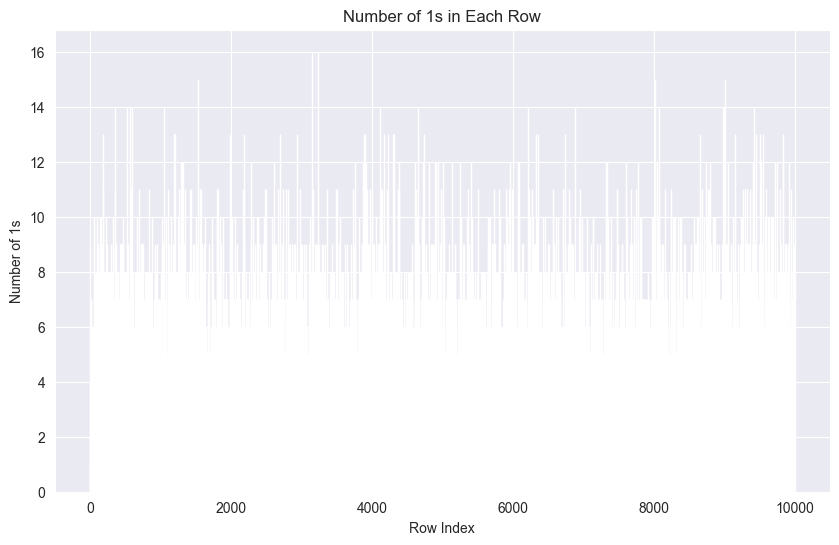

In [228]:


# Ensure all column names are strings
sample_recipe.columns = sample_recipe.columns.astype(str)

# Create a DataFrame to hold the new columns with initial values set to 0
ingredient_list = ingr_mapping_df['ingredient_name'].unique()
new_columns_ingr_df = pd.DataFrame(0, index=sample_recipe.index, columns=ingredient_list)

# Concatenate the new columns to sample_recipe
sample_recipe = pd.concat([sample_recipe, new_columns_ingr_df], axis=1)

# Iterate through sample_recipe NER column rows
for index, row in sample_recipe.iterrows():
 ingredients_list = row['NER']
 # Iterate through each value in the ingredients list
 for ingredient in ingredients_list:
  # Check if the ingredient matches any column name
  if ingredient in sample_recipe.columns:
   # Update the corresponding cell to 1
   sample_recipe.at[index, ingredient] = 1

# Calculate the number of 1s in each row
# Identify columns that are compound IDs
ingredient_cols = [col for col in sample_recipe.columns if col not in ['id', 'NER', 'total_ingredients', 'matched_ingredients']]
sample_recipe['matched_ingredients'] = sample_recipe[ingredient_cols].sum(axis=1)


# Plot the number of 1s in each row
plt.figure(figsize=(10, 6))
plt.bar(sample_recipe.index, sample_recipe['matched_ingredients'])
plt.xlabel('Row Index')
plt.ylabel('Number of 1s')
plt.title('Number of 1s in Each Row')
plt.show()

In [234]:
# Ensure existing columns are retained
existing_columns = sample_recipe.columns.tolist()

# Specify the desired columns order
desired_columns = ['id', 'NER', 'total_ingredients', 'matched_ingredients', 'matched_percentage']

# Filter out the desired columns from the existing columns list
remaining_columns = [col for col in existing_columns if col not in desired_columns]

# Combine desired columns with the remaining columns
new_columns_order = desired_columns + remaining_columns

# Reassign the DataFrame columns
sample_recipe = sample_recipe[new_columns_order]

sample_recipe.head()

,id,NER,total_ingredients,matched_ingredients,matched_percentage,magnolia_tripetala,calyptranthes_parriculata,chamaecyparis_pisifera_oil,mackerel,mimusops_elengi_flower,...,rue_oil,roasted_coconut,cajeput_oil,star_anise,feijoa,tobacco_oil,cinnamon_leaf,green_tea,artemisia_porrecta_oil,munster_cheese
0,0,"[flank_steak, brown_sugar, soy_sauce, sesame_s...",10,4,40.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,"[carrot, water, handful_grape_tomatoes, mushro...",17,9,52.941176,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,"[carrot, brown_sugar, butter, lemon_rind]",4,2,50.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,"[water, crisco, vinegar, salt, baking_powder, ...",8,2,25.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,"[thin_pretzels, margarine]",2,0,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [232]:
sample_recipe

,id,NER,total_ingredients,matched_ingredients,magnolia_tripetala,calyptranthes_parriculata,chamaecyparis_pisifera_oil,mackerel,mimusops_elengi_flower,hyssop,...,rue_oil,roasted_coconut,cajeput_oil,star_anise,feijoa,tobacco_oil,cinnamon_leaf,green_tea,artemisia_porrecta_oil,munster_cheese
0,0,"[flank_steak, brown_sugar, soy_sauce, sesame_s...",10,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,"[carrot, water, handful_grape_tomatoes, mushro...",17,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,"[carrot, brown_sugar, butter, lemon_rind]",4,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,"[water, crisco, vinegar, salt, baking_powder, ...",8,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,"[thin_pretzels, margarine]",2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,"[ground_nutmeg, sultana, milk, rolled_oats, or...",13,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,9996,"[carrot, walnut, mandarin_oranges, olive_oil, ...",16,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,9997,"[tomato, onion, longgrain_white_rice, ground_b...",5,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,9998,"[fingerling_potatoes, garlic, onion_salt, ital...",12,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


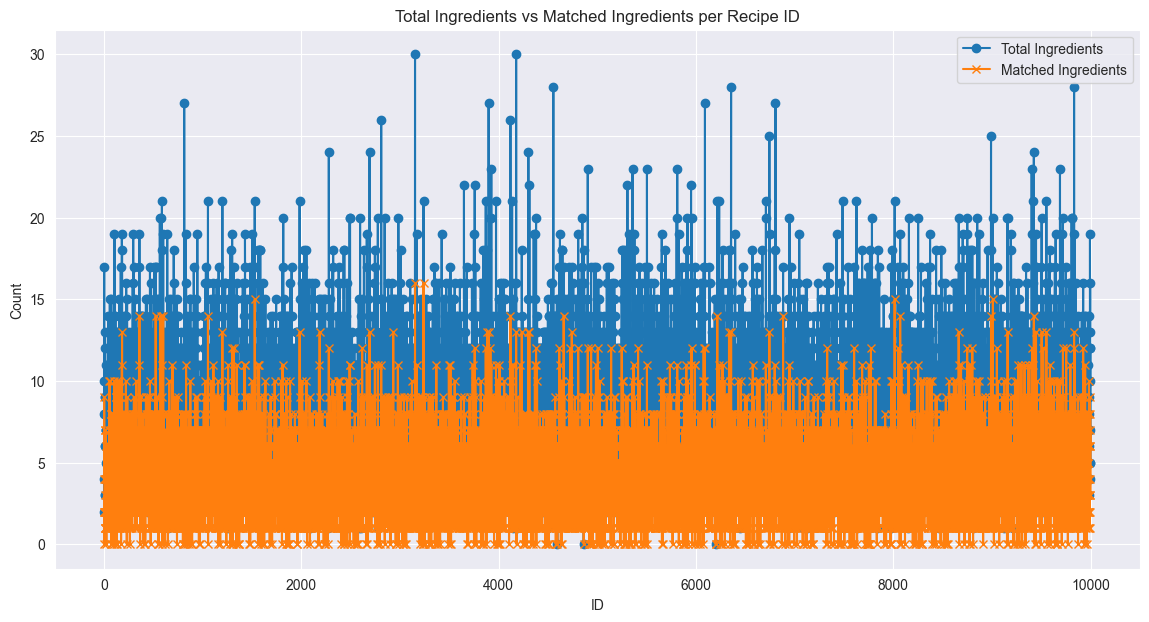

In [230]:
# Sort the DataFrame by 'id' to ensure the trend lines are accurate
sample_recipe_sorted = sample_recipe.sort_values(by='id')

# Plot the trend lines
plt.figure(figsize=(14, 7))

plt.plot(sample_recipe_sorted['id'], sample_recipe_sorted['total_ingredients'], label='Total Ingredients', marker='o')
plt.plot(sample_recipe_sorted['id'], sample_recipe_sorted['matched_ingredients'], label='Matched Ingredients', marker='x')

plt.xlabel('ID')
plt.ylabel('Count')
plt.title('Total Ingredients vs Matched Ingredients per Recipe ID')
plt.legend()

plt.grid(True)
plt.show()

In [231]:
zero_matched_ingredients_count = sample_recipe[sample_recipe['matched_ingredients'] == 0].shape[0]

print(f"Number of ids with 0 matched ingredients: {zero_matched_ingredients_count}")

Number of ids with 0 matched ingredients: 295


In [233]:
sample_recipe['matched_percentage'] = (sample_recipe['matched_ingredients'] / sample_recipe['total_ingredients']) * 100

# Filter out recipes with less than 60% matched ingredients
filtered_sample_recipe = sample_recipe[sample_recipe['matched_percentage'] >= 60]

# Drop the 'matched_percentage' column if no longer needed
filtered_sample_recipe.drop(columns=['matched_percentage'], inplace=True)

# Verify the result
filtered_sample_recipe.head()

/var/folders/sx/vzszgjy10_z93jmql4144jnm0000gn/T/ipykernel_65410/2329362807.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sample_recipe.drop(columns=['matched_percentage'], inplace=True)


,id,NER,total_ingredients,matched_ingredients,magnolia_tripetala,calyptranthes_parriculata,chamaecyparis_pisifera_oil,mackerel,mimusops_elengi_flower,hyssop,...,rue_oil,roasted_coconut,cajeput_oil,star_anise,feijoa,tobacco_oil,cinnamon_leaf,green_tea,artemisia_porrecta_oil,munster_cheese
5,5,"[sugar, lemon_juice, orange_juice]",3,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,14,"[flour, mustard, vinegar, onion, celery, vegal...",10,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,17,"[syrup, lemon_juice, orange_juice, sugar, bana...",8,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,26,"[green_onion, egg, swiss_cheese, milk, refrige...",7,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,29,"[ranch_style_beans, onion, beans, green_bell_p...",5,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [235]:
filtered_sample_recipe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3023 entries, 5 to 9999
Columns: 1534 entries, id to munster_cheese
dtypes: int64(1533), object(1)
memory usage: 35.4+ MB


In [267]:
ingredient_dic

{'mentha_crispa': [],
 'winter_savory': [],
 'mentha_verticillata': [],
 'honey_fungus': [],
 'japanese_mint': [],
 'smoked_summer_sausage': ['summer_sausage'],
 'bulgarian_clary_sage': [],
 'smoked_sausage': [],
 'celery_seed': ['celery_seeds'],
 'celery_oil': ['celery_salt'],
 'licorice': [],
 'hazelnut': ['hazelnut_meal', 'hazelnuts'],
 'roasted_hazelnut': ['ground_hazelnuts'],
 'estragon': [],
 'estragon_oil': [],
 'cod': [],
 'bitter_fennel': [],
 'beet_juice': [],
 'roasted_beef': ['stew_beef', 'beef_roast', 'roast_beef'],
 'myrrh_oil': [],
 'litsea_guatemalensis': [],
 'litsea_guatemalensis_oil': [],
 'chamaecyparis_pisifera': [],
 'chamaecyparis_pisifera_oil': [],
 'cherry_juice': [],
 'black_chokecherry': [],
 'pandanus_odoratissimus': [],
 'pandanus_odoratissimus_oil': [],
 'kabosu_peel_oil': [],
 'teucrium_chamaedrys': [],
 'american_storax': [],
 'savory': [],
 'summer_savory': [],
 'turpentine': [],
 'pine_turpentine': [],
 'grilled_beef': [],
 'irish_whiskey': ['rye_whisk

In [239]:
# Convert dictionary to DataFrame
ingredient_dic_df = pd.DataFrame.from_dict(ingredient_dic, orient='index', columns=['matches'])



ValueError: 1 columns passed, passed data had 130 columns

In [238]:
ingredient_dic_df

NameError: name 'ingredient_dic_df' is not defined

In [240]:
ingredient_dic

{'mentha_crispa': [],
 'winter_savory': [],
 'mentha_verticillata': [],
 'honey_fungus': [],
 'japanese_mint': [],
 'smoked_summer_sausage': ['summer_sausage',
  'summer_sausage',
  'summer_sausage',
  'summer_sausage',
  'summer_sausage',
  'summer_sausage',
  'summer_sausage'],
 'bulgarian_clary_sage': [],
 'smoked_sausage': [],
 'celery_seed': ['celery_seeds'],
 'celery_oil': ['celery_salt',
  'celery_salt',
  'celery_salt',
  'celery_salt',
  'celery_salt',
  'celery_salt',
  'celery_salt'],
 'licorice': [],
 'hazelnut': ['hazelnuts',
  'hazelnut_meal',
  'hazelnut_meal',
  'hazelnut_meal',
  'hazelnut_meal',
  'hazelnut_meal',
  'hazelnut_meal',
  'hazelnut_meal'],
 'roasted_hazelnut': ['ground_hazelnuts',
  'ground_hazelnuts',
  'ground_hazelnuts',
  'ground_hazelnuts',
  'ground_hazelnuts',
  'ground_hazelnuts',
  'ground_hazelnuts'],
 'estragon': [],
 'estragon_oil': [],
 'cod': [],
 'bitter_fennel': [],
 'beet_juice': [],
 'roasted_beef': ['roast_beef',
  'stew_beef',
  'stew_

In [241]:
# Remove duplicates within each list
ingredient_dic = {k: list(set(v)) for k, v in ingredient_dic.items()}

In [242]:
# Convert dictionary to DataFrame
ingredient_dic_df = pd.DataFrame.from_dict(ingredient_dic, orient='index').transpose()

In [243]:
# Fill None for missing values
ingredient_dic_df.fillna('', inplace=True)

In [245]:
# Export DataFrame to CSV
ingredient_dic_df.to_csv('data/ingredient_dic.csv', index_label='ingredient')

In [258]:
import json
import pandas as pd

def export_ingredient_dic(ingredient_dic, filename, file_format='json'):
    if file_format == 'json':
        with open(filename, 'w') as json_file:
            json.dump(ingredient_dic, json_file)
    elif file_format == 'csv':
        # Convert dictionary to DataFrame
        ingredient_dic_df = pd.DataFrame.from_dict(ingredient_dic, orient='index')
        # Rename columns if there are multiple matches
        ingredient_dic_df.columns = [f'match_{i+1}' for i in range(ingredient_dic_df.shape[1])]
        # Export DataFrame to CSV
        ingredient_dic_df.to_csv(filename, index_label='ingredient')
    else:
        raise ValueError("Unsupported file format. Use 'json' or 'csv'.")



In [268]:
# Example usage
export_ingredient_dic(ingredient_dic, filename='ingredient_dic.json', file_format='json')

In [ ]:
prova = 